In [761]:
import pandas as pd
import numpy as np
import pymorphy2
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import sklearn.manifold as sm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import MeanShift
from sklearn.decomposition import TruncatedSVD
import networkx as nx

RusLem = pymorphy2.MorphAnalyzer()

def bprint(l, sep = " "):
    if len(l) == 0:
        print ""
    print sep.join(l)

In [794]:
train_data = pd.read_csv("./russe-wsi-kit/data/main/wiki-wiki/train.csv", dtype={'gold_sense_id': str, 'predict_sense_id': str}, 
                                                             sep = '\t')

In [796]:
print train_data['context'][0]

замок владимира мономаха в любече . многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости . ранние европейские замки строились преимущественно из дерева они опоясывались деревянной оградой — палисадом уже тогда вокруг замков стали появляться рвы . примером такого замка может служить вышгородский замок киевских князей . каменное замковое строительство распространилось в западной и центральной европе лишь к xii веку . главной частью средневекового замка являлась центральная башня — донжон , выполнявшая функции цитадели . помимо своих оборонительных функций , донжон являлся непосредственным жилищем феодала . также в главной башне


In [793]:
train_data['word' == 'суда']

KeyError: False

In [577]:
train_data

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
2,3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании м..."
4,5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...
5,6,замок,1,NaN,"42-47, 281-286",его без боя . в начале xviii века высокий замо...
6,7,замок,1,NaN,"260-265, 495-500",", колодец , хозяйственные помещения ( склады п..."
7,8,замок,1,NaN,"197-202, 205-210, 415-420",— сын гедимина трокский князь кейстут . около ...
8,9,замок,1,NaN,"28-33, 196-201, 257-262, 417-422",одним из кэмпбеллов — отдал замок в обмен на в...
9,10,замок,1,NaN,"0-5, 14-19, 175-180",замок сталкер замок был построен в г . и перв...


In [578]:
def lematization(sent):
    tokens = re.findall('[\w,.]+', sent.decode("utf-8").strip().lower(), re.U)
    return " ".join([RusLem.parse(token)[0].normal_form for token in tokens])

In [624]:
# train_data['context'] = np.asarray([lematization(row) for row in train_data['context']])
train_data['context'] = np.asarray([row.decode('utf-8') for row in train_data['context']])
train_data['word'] = np.asarray([row.decode("utf-8") for row in train_data['word']])

In [756]:
def jaccard_index(list_1, list_2):
    set_1 = set(list_1)
    set_2 = set(list_2)
    if len(list_1) == 0 and len(list_2) == 0:
        return 0
    return (len(list(set_1.intersection(set_2))) * 1.) / len(list(set_1.union(set_2)))

def context_similarity(context_1, context_2):
#     print context_idx_1, context_idx_2
#     try:
#         context_idx_1 = int(context_idx_1[0])
#         context_idx_2 = int(context_idx_2[0])
#     finally:
#         return 1
#     context_1 = word_contexts[word][int(context_idx_1[0])]
#     context_2 = word_contexts[word][int(context_idx_2[0])]
    adjs_coef = 1.
    preps_coef = 1.
    verbs_coef = 1.
    left_nouns_coef = 1.
    right_nouns_coef = 1.
    
    if context_1.context_id == context_2.context_id:
        return 0
    
    sim = jaccard_index(context_1.adjs, context_2.adjs) * adjs_coef +\
        jaccard_index(context_1.preps, context_2.preps) * preps_coef +\
        jaccard_index(context_1.verbs, context_2.verbs) * verbs_coef +\
        jaccard_index(context_1.left_nouns, context_2.left_nouns) * left_nouns_coef +\
        jaccard_index(context_1.right_nouns, context_2.right_nouns) * right_nouns_coef
        
    return sim

class Context():
    def __init__(self, context_id, context, word, positions):
        self.context_id = context_id
        self.context = context
        self.word = word
        
        lf = LocalFeatureExtractor(context, word, positions)
        
        self.adjs = lf.left_adjective()
        print ("agjs")
        bprint(self.adjs)
        self.preps = lf.left_prep()
        print ("preps")
        bprint(self.preps)
        self.verbs = lf.nearest_verb()
        print ("verbs")
        bprint(self.verbs)
        self.left_nouns = lf.left_noun()
        print ("left nouns")
        bprint(self.left_nouns)
        self.right_nouns = lf.right_noun()
        print ("right noun")
        bprint (self.right_nouns)

class LocalFeatureExtractor():
    def __init__(self, context, word, positions):
        self.context = context
        self.word = word
        self.positions = self.get_positions(positions)
        self.punctuation = ".,;:\"?!"
        
    def get_positions(self, positions):
        return [[int(m.strip().split("-")[0]), int(m.strip().split("-")[1])] 
                for m in positions.strip().split(",")]
#         return [m.start() for m in re.finditer(self.word, self.context)]
    
    def get_area(self, word_position, left_side=True, right_side=True):
        """
        return index of left and right border until punctuation
        """
        left_border = word_position[0]
        right_border = word_position[1]
        
        if left_side:
            while left_border >= 0:
                if self.context[left_border] not in self.punctuation:
                    left_border -= 1
                else:
                    break
                    
        if right_side:
            while right_border < len(self.context):
                if self.context[right_border] not in self.punctuation:
                    right_border += 1
                else:
                    break
                    
        if right_side == False:
            right_border = word_position[0]
        
        if left_side == False:
            left_border = word_position[1]
                    
        return left_border + 1, right_border
    
    def left_adjective(self):
        adjs = []
        for position in self.positions[:]:
            left_border, right_border = self.get_area(position, right_side=False)
#             print left_border, right_border, self.context[left_border:right_border]
            tokens = re.findall('[\w]+', 
                                self.context[left_border:right_border].strip(),
                                re.U)
            for token in tokens[::-1]:
                prepared_token = RusLem.parse(token)[0].normal_form
#                 print prepared_token
                if RusLem.parse(prepared_token)[0].tag.POS == 'ADJF':
                    adjs.append(prepared_token)
                else:
                    break
        return list(set(adjs))
    
    def left_prep(self):
        preps = []
        for position in self.positions[:]:
            left_border, right_border = self.get_area(position, right_side=False)
            tokens = re.findall('[\w]+', 
                                self.context[left_border:right_border].strip(),
                                re.U)
            for token in tokens[::-1]:
                prepared_token = RusLem.parse(token)[0].normal_form
                if RusLem.parse(prepared_token)[0].tag.POS == 'PREP':
                    preps.append(prepared_token)
                    break
                elif RusLem.parse(prepared_token)[0].tag.POS == 'ADJF':
                    continue
                else:
                    break
                    
        return list(set(preps))
    
    def left_noun(self):
        nouns = []
        for position in self.positions[:]:
            left_border, right_border = self.get_area(position, right_side=False)
            tokens = re.findall('[\w]+', 
                                self.context[left_border:right_border].strip(),
                                re.U)
            
            possible_prep_cnt = 1
            for token in tokens[::-1]:
                prepared_token = RusLem.parse(token)[0].normal_form
                if RusLem.parse(prepared_token)[0].tag.POS == 'NOUN':
                    nouns.append(prepared_token)
                    break
                elif RusLem.parse(prepared_token)[0].tag.POS == 'ADJF':
                    continue
                elif RusLem.parse(prepared_token)[0].tag.POS == 'PREP':
                    if possible_prep_cnt > 0:
                        possible_prep_cnt -= 1
                    else:
                        break
                else:
                    break
                    
        return list(set(nouns))
    
    def right_noun(self):
        nouns = []
        for position in self.positions[:]:
            left_border, right_border = self.get_area(position, left_side=False)
            tokens = re.findall('[\w]+', 
                                self.context[left_border:right_border].strip(),
                                re.U)
            
            possible_prep_cnt = 1
            for token in tokens[::]:
                prepared_token = RusLem.parse(token)[0].normal_form
                if RusLem.parse(prepared_token)[0].tag.POS == 'NOUN':
                    nouns.append(prepared_token)
                    break
                elif RusLem.parse(prepared_token)[0].tag.POS == 'ADJF':
                    continue
                elif RusLem.parse(prepared_token)[0].tag.POS == 'PREP':
                    if possible_prep_cnt > 0:
                        possible_prep_cnt -= 1
                    else:
                        break
                else:
                    break
                    
        return list(set(nouns))
                    
    def nearest_verb(self):
        verbs = []
        for position in self.positions[:]:
            left_border, right_border = self.get_area(position)
            
            left_tokens = re.findall('[\w]+', 
                                self.context[left_border:position[0]].strip(),
                                re.U)
            
            right_tokens = re.findall('[\w]+', 
                                self.context[position[1]:right_border].strip(),
                                re.U)
            
            cnt_between_word = 1
            for token in left_tokens[::-1]:
                prepared_token = RusLem.parse(token)[0].normal_form
                if RusLem.parse(prepared_token)[0].tag.POS == 'INFN' or RusLem.parse(prepared_token)[0].tag.POS == 'VERB':
                    verbs.append(token)
                elif RusLem.parse(prepared_token)[0].tag.POS != "NOUN":
                    if cnt_between_word > 0:
                        cnt_between_word -= 1
                        continue
                    else:
                        break
                else:
                    break
                    
            cnt_between_word = 1
            for token in right_tokens[::]:
                prepared_token = RusLem.parse(token)[0].normal_form
                if RusLem.parse(prepared_token)[0].tag.POS == 'INFN' or RusLem.parse(prepared_token)[0].tag.POS == 'VERB':
                    verbs.append(prepared_token)
                elif RusLem.parse(prepared_token)[0].tag.POS != "NOUN":
                    if cnt_between_word > 0:
                        cnt_between_word -= 1
                        continue
                    else:
                        break
                else:
                    break

        return list(set(verbs))

In [681]:
print RusLem.parse(u"владимир")[0]

Parse(word=u'\u0432\u043b\u0430\u0434\u0438\u043c\u0438\u0440', tag=OpencorporaTag('NOUN,anim,masc,Name sing,nomn'), normal_form=u'\u0432\u043b\u0430\u0434\u0438\u043c\u0438\u0440', score=0.983606, methods_stack=((DictionaryAnalyzer(), u'\u0432\u043b\u0430\u0434\u0438\u043c\u0438\u0440', 27, 0),))


In [757]:
# lf = LocalFeatureExtractor(train_data['context'][0], u"зaмок")
print train_data['context'].values[0][:]
lf = LocalFeatureExtractor(train_data['context'][0], train_data['word'][0], train_data['positions'][0])
print lf.positions
adjs = lf.left_adjective()
print "adjs"
bprint(adjs)
preps = lf.left_prep()
print "preps"
bprint(preps)
verbs = lf.nearest_verb()
print "verbs"
bprint(verbs)
left_nouns = lf.left_noun()
print "left_nouns"
bprint(left_nouns)
right_nouns = lf.right_noun()
print "right_nouns"
bprint(right_nouns)

замок владимира мономаха в любече . многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости . ранние европейские замки строились преимущественно из дерева они опоясывались деревянной оградой — палисадом уже тогда вокруг замков стали появляться рвы . примером такого замка может служить вышгородский замок киевских князей . каменное замковое строительство распространилось в западной и центральной европе лишь к xii веку . главной частью средневекового замка являлась центральная башня — донжон , выполнявшая функции цитадели . помимо своих оборонительных функций , донжон являлся непосредственным жилищем феодала . также в главной башне
[[0, 5], [339, 344]]
adjs
вышгородский
preps


verbs
служить
left_nouns


right_nouns
владимир князь


In [689]:
for context_idx, context in enumerate(word_df[u"замок"][['gold_sense_id','context', 'positions']].values):
    print idx, context[0]
    lf = LocalFeatureExtractor(context[1], "замок", context[2])
#     adjs = lf.left_adjective()
#     bprint(adjs)
    verbs = lf.nearest_verb()
    bprint(verbs)

438 1
[[0, 5], [339, 344]]
служить
438 1
[[11, 16], [17, 22], [188, 193]]
представлять
438 1
[[299, 304]]


438 1
[[111, 116]]


438 1
[[134, 139], [262, 267]]
стоял перенести
438 1
[[42, 47], [281, 286]]
захватить разобрать быть
438 1
[[260, 265], [495, 500]]
иметь быть
438 1
[[197, 202], [205, 210], [415, 420]]
был построен
438 1
[[28, 33], [196, 201], [257, 262], [417, 422]]
осаждали отдал использовать обязали передать
438 1
[[0, 5], [14, 19], [175, 180]]
быть построить
438 1
[[0, 5], [16, 21], [179, 184], [291, 296], [468, 473]]
стоит попасть быть
438 1
[[0, 5], [176, 181], [292, 297]]
выстроить служить основать быть
438 1
[[14, 19], [22, 27], [232, 237]]
быть построить
438 1
[[252, 257]]
стать
438 1
[[11, 16], [17, 22], [188, 193], [274, 279]]
представлять стоить
438 1
[[94, 99], [226, 231]]
превратиться посетить
438 1
[[124, 129], [233, 238]]
стать
438 1
[[11, 16], [19, 24], [82, 87], [275, 280]]


438 1
[[59, 64], [285, 290]]
предприниматься
438 1
[[336, 341], [494, 499], [540, 

In [697]:
word_contexts = {}
for group in word_groups:
    word_contexts[group[0]] = []
#     print group[1][['context_id', 'context']]
    for c in group[1][['context_id', 'context', 'positions']].values:
        print c[0], c[1], group[0]
        word_contexts[group[0]].append(Context(c[0], c[1], group[0], c[2]))

384 бор ( элемент ) бор — элемент тринадцатой группы ( по устаревшей классификации — главной подгруппы третьей группы ) , второго периода периодической системы химических элементов с атомным номером . обозначается символом b ( ) . в свободном состоянии бор
agjs


preps


verbs


left nouns
элемент
right noun
элемент
T бор - углерод - кремний семейство сплавов на основе системы бор - углерод - кремний — сверхтвердый материал с микротвердостью , превышающей гпа . чрезвычайно устойчив к химическим воздействиям и высокой температуре . считается одним из лучших абразивных материалов по соотношению цена - производительность . бор
agjs


preps


verbs


left nouns
система
right noun
углерод
386 с большим выделением теплоты , образуется оксид b o данное свойство бора можно объяснить очень высокой прочностью химических связей в оксиде бора b o . при отсутствии окислителей бор устойчив к действию растворов щелочей . в горячей азотной , серной кислотах и в царской водке бор растворяется с образов

суда
135


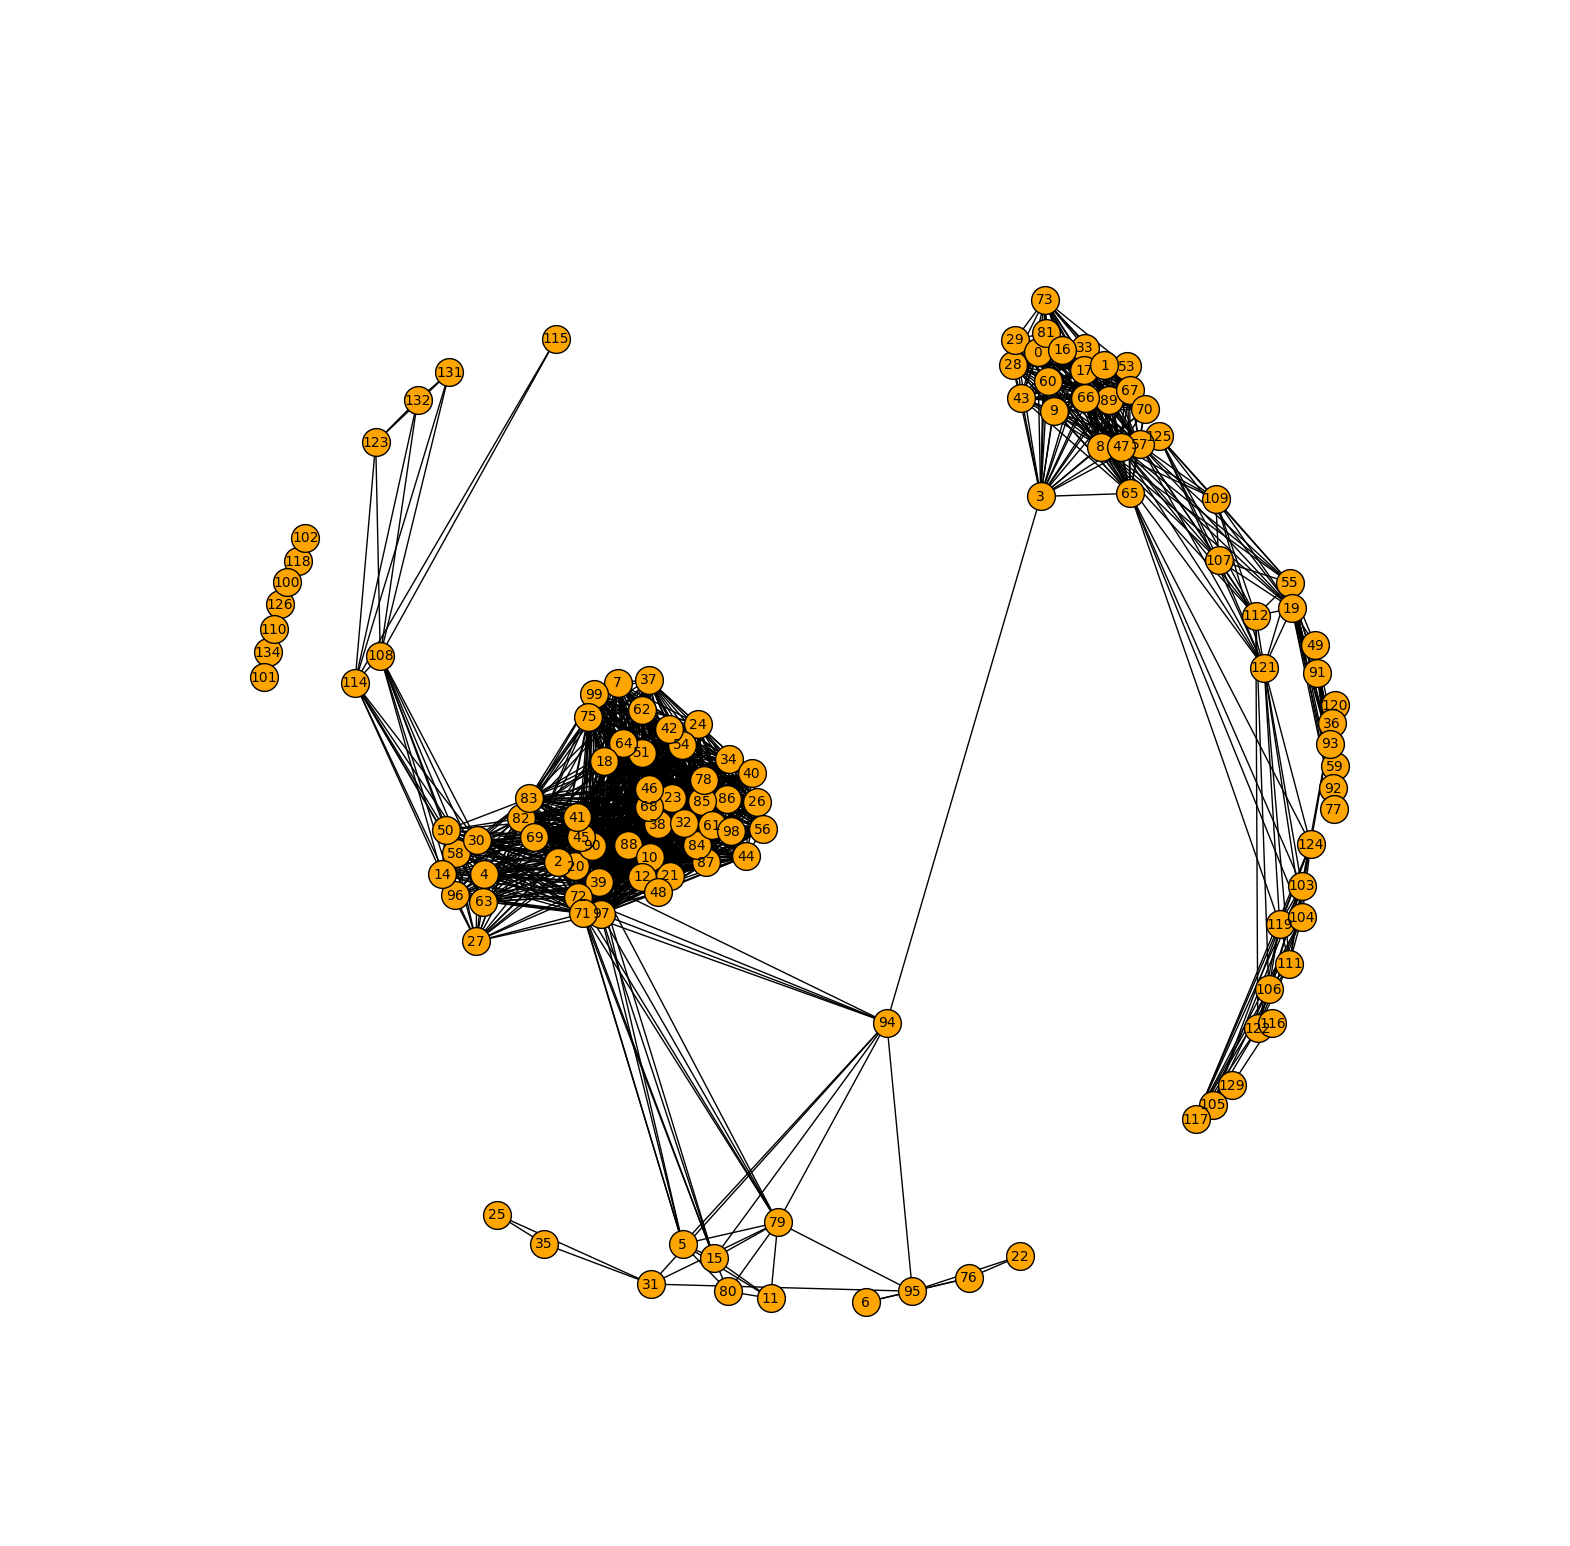

In [789]:
word_dist = {}
plt.figure(figsize=(15, 15))
for word in word_contexts.keys()[:1]:
    print word
    G = nx.Graph()
    contexts = word_contexts[word]
    print len(contexts)
    dist = np.zeros((len(contexts), len(contexts)))
    for i1, c1 in enumerate(contexts):
        for i2, c2 in enumerate(contexts):
            dist[i1, i2] = context_similarity(c1, c2)
            if dist[i1, i2] > 0:
#                 G.add_edge(str(i1), str(i2), weight=5 - dist[i1, i2])
                G.add_edge(str(i1), str(i2), weight=dist[i1, i2])
    nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=10)
    plt.show()
   
    
#     G.add_edge('A', 'B', weight=4)
#     G.add_edge('B', 'D', weight=2)
#     G.add_edge('A', 'C', weight=3)nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

#     G.add_edge('C', 'D', weight=4)

In [782]:
print dist[119, 132]
print dist[74, 97]
print dist[75,78]
print dist[75, 16]

0.5
1.0
2.0
0.5


In [753]:


word_labels = {}
for word in word_contexts.keys():
#     word_labels[word] = DBSCAN(eps=0.88, min_samples=0, metric='cosine').fit_predict(word_tfidf[word])
    word_labels[word] = DBSCAN(eps=0.99999, min_samples=0, 
                               metric=context_similarity, metric_params = {"word":word}).fit_predict(
                                                np.asarray([[i] for i in range(len(word_contexts[word]))]))
#     word_labels[word] = MeanShift().fit_predict(word_tfidf[word])

In [758]:
for word in word_labels.keys():
    print word
    print len(set(word_labels[word]))
    print word_labels[word]

суда
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
замок
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
бор
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
лук
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [728]:
print len(word_contexts[u"замок"])

138


In [500]:
print train_data['context'][0]

замок владимир мономах в любечий . многочисленный укрепить монастырь также не являться замок как таковой это быть крепость . ранний европейский замок строиться преимущественно из дерево они опоясываться деревянный ограда палисад уже тогда вокруг замок стать появляться ров . пример такой замок мочь служить вышгородский замок киевский князь . каменный замковый строительство распространиться в западный и центральный европа лишь к xii век . главный часть средневековый замок являться центральный башня донжон , выполнять функция цитадель . помимо свой оборонительный функция , донжон являться непосредственный жилище феодал . также в главный башня


In [344]:
print train_data['context'][1]

шильонский замок замок шильйон ( ) , известный в русскоязычной литературе как шильо́нский за́мок , расположен на швейцарской ривьере , у кромки женевского озера , в  км от города монтре . замок представляет собой комплекс из элементов разного времени постройки .


In [686]:
word_groups = train_data.groupby('word')

In [29]:
word_groups.describe()

/home/dana_zl/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


positions
word                  
бор   count        0.0
      mean         NaN
      std          NaN
      min          NaN
      25%          NaN
      50%          NaN
      75%          NaN
      max          NaN
замок count        0.0
      mean         NaN
      std          NaN
      min          NaN
      25%          NaN
      50%          NaN
      75%          NaN
      max          NaN
лук   count        0.0
      mean         NaN
      std          NaN
      min          NaN
      25%          NaN
      50%          NaN
      75%          NaN
      max          NaN
суда  count        0.0
      mean         NaN
      std          NaN
      min          NaN
      25%          NaN
      50%          NaN
      75%          NaN
      max          NaN

In [687]:
word_df = {}
for group in word_groups:
    word_df[group[0]] = group[1]

In [583]:
bprint(word_df.keys())

бор суда замок лук


In [584]:
bor_contexts = word_df['бор']['context'].values

In [585]:
word_binary = {}
binary_vectorizer = CountVectorizer(binary=True)
tfidf_vectorizer = TfidfVectorizer()
for word in word_df.keys():
#     word_tfidf[word] = tfidf_vectorizer.fit_transform(word_contexts[word]['context'].values).toarray()
    word_binary[word] = binary_vectorizer.fit_transform(word_df[word]['context'].values).toarray()
    print word, word_binary[word].shape

бор (56, 809)
суда (135, 1361)
замок (138, 1816)
лук (110, 1531)


In [586]:
word_binary_lsa = {}
for word in word_binary.keys():
    word_binary_lsa[word] = TruncatedSVD(n_components=20, n_iter=400).fit_transform(word_binary[word])

In [587]:
print word_binary_lsa["бор"]

[[ 0.82861813 -0.2565993   0.1544886  ...,  0.08785744 -0.40825306
  -0.12042516]
 [ 1.29892505 -0.18287333  0.68773044 ..., -0.07899947 -0.57014413
  -0.27331183]
 [ 2.15780308  0.12549255  4.60330105 ..., -0.36324091 -0.17461279
  -0.9565759 ]
 ..., 
 [ 2.3907476  -0.56826789  0.02295435 ..., -3.34036338  0.39740658
  -0.35263781]
 [ 1.28620771 -0.20075096 -0.35436812 ..., -0.39968361 -0.31338451
  -0.19100296]
 [ 1.80778015  0.49452738 -0.77058361 ...,  0.43366457 -0.18357566
   0.16507277]]


In [617]:
word_labels_lsa = {}
eps = {'бор':0.58, 'суда':0.45, 'замок':0.4, 'лук':0.4}
for word in word_binary_lsa.keys():
#     word_labels[word] = DBSCAN(eps=0.88, min_samples=0, metric='cosine').fit_predict(word_tfidf[word])
    word_labels_lsa[word] = DBSCAN(eps=eps[word], min_samples=0, metric='cosine').fit_predict(word_binary_lsa[word])
#     word_labels[word] = MeanShift().fit_predict(word_tfidf[word])

In [618]:
for word in word_labels_lsa.keys():
    print word
    print len(set(word_labels_lsa[word]))
    print word_labels_lsa[word]

бор
5
[0 0 1 0 0 2 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 0 3 0 0 0
 0 0 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
суда
3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 1 0 0 0 0 2 2 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
замок
3
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
лук
5
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 3 0
 4 0 0 4 3 0 0 0 0 4 3 0 0 0 2 4 0 0 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [334]:
word_labels = {}
for word in word_contexts.keys():
#     word_labels[word] = DBSCAN(eps=0.88, min_samples=0, metric='cosine').fit_predict(word_tfidf[word])
    word_labels[word] = DBSCAN(eps=0.825, min_samples=0, metric='cosine').fit_predict(word_binary[word])
#     word_labels[word] = MeanShift().fit_predict(word_tfidf[word])

In [335]:
for word in word_labels.keys():
    print word
    print len(set(word_labels[word]))
    print word_labels[word]

бор
5
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 4 0]
лук
3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
суда
3
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0]
замок
6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]


In [256]:
train_data

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,NaN,замок владимир мономах в любечий многочисленны...
1,2,замок,1,NaN,NaN,шильонский замок замок шильйон известный в рус...
2,3,замок,1,NaN,NaN,проведение архитектурный археологический работ...
3,4,замок,1,NaN,NaN,топь с л белокуров легенда о завещание мавр с ...
4,5,замок,1,NaN,NaN,великий князь литовский гедимин после успешный...
5,6,замок,1,NaN,NaN,он без бой в начало xviii век высокий замок за...
6,7,замок,1,NaN,NaN,колодец хозяйственный помещение склад продовол...
7,8,замок,1,NaN,NaN,сын гедимин трокский князь кейстут около год в...
8,9,замок,1,NaN,NaN,один из кэмпбелл отдать замок в обмен на восьм...
9,10,замок,1,NaN,NaN,замок сталкер замок быть построить в г и перво...


In [619]:
word_idx = {word: 0 for word in word_labels_lsa}
for idx, row in train_data.iterrows():
#     print idx
#     print word_labels[row['word']][word_idx[row['word']]]
    train_data['predict_sense_id'].iloc[idx] = word_labels_lsa[row['word']][word_idx[row['word']]]
#     print row
    word_idx[row['word']] += 1

In [620]:
train_data

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,0,"0-5, 339-344",замок владимир мономах в любечий . многочислен...
1,2,замок,1,0,"11-16, 17-22, 188-193","шильонский замок замок шильйон , известный в р..."
2,3,замок,1,0,299-304,проведение архитектурный археологический работ...
3,4,замок,1,0,111-116,"топь с . , л . белокуров легенда о завещание м..."
4,5,замок,1,0,"134-139, 262-267",великий князь литовский гедимин после успешный...
5,6,замок,1,0,"42-47, 281-286",он без бой . в начало xviii век высокий замок ...
6,7,замок,1,1,"260-265, 495-500",", колодец , хозяйственный помещение склад прод..."
7,8,замок,1,0,"197-202, 205-210, 415-420",сын гедимин трокский князь кейстут . около год...
8,9,замок,1,0,"28-33, 196-201, 257-262, 417-422",один из кэмпбелл отдать замок в обмен на восьм...
9,10,замок,1,0,"0-5, 14-19, 175-180",замок сталкер замок быть построить в г . и пер...


In [621]:
# train_data['context'] = train_data['context'].apply(lambda x: x.encode("utf-8"))
train_data.to_csv("./russe-wsi-kit/data/main/wiki-wiki/train_binar_lsa.csv", encoding="utf-8", index=False, sep='\t')

In [252]:
tsne = sm.TSNE(n_components=2, metric = 'cosine', perplexity=7, verbose=1, n_iter=100000)
word_tsne = {}
for word in word_labels.keys():
    word_tsne[word] = tsne.fit_transform(word_tfidf[word])

[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 56 samples in 0.000s...
[t-SNE] Computed neighbors for 56 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 56 / 56
[t-SNE] Mean sigma: 0.283285
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.936684
[t-SNE] Error after 3100 iterations: 0.279019
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 0.241402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.001190
[t-SNE] Error after 2100 iterations: 0.688076
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 135 samples in 0.000s...
[t-SNE] Computed neighbors for 135 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 135 / 135
[t-SNE] Mean sigma: 0.297931
[t-SNE] KL divergence after 250 iterations with early exagge

In [253]:
bprint (word_tsne.keys())

замок бор суда лук


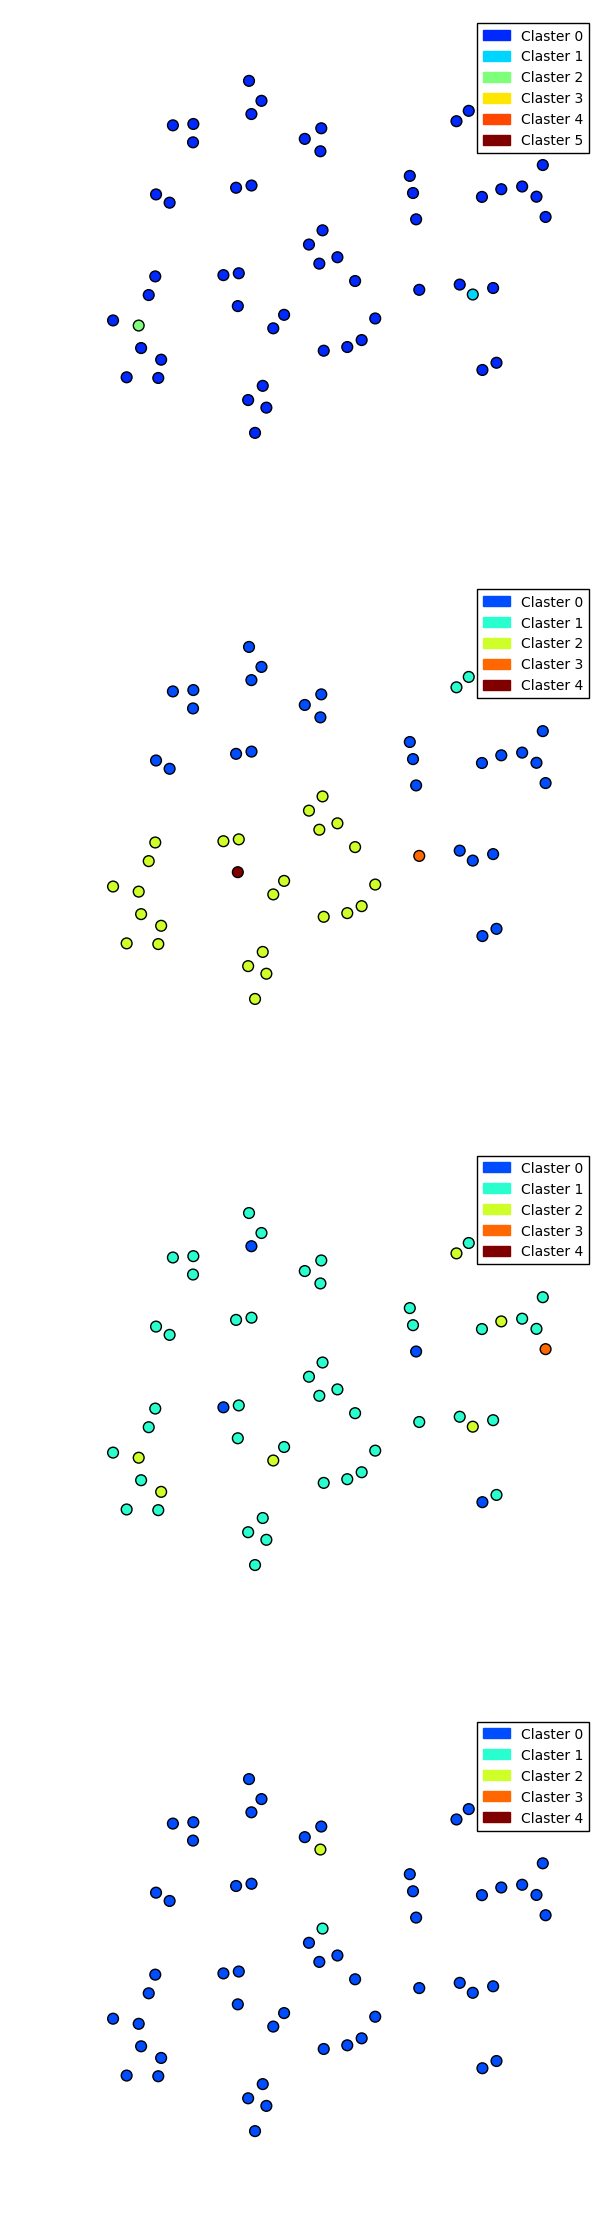

In [254]:
fig = plt.figure(figsize=(7, 28))
for word_idx, word in enumerate(word_tsne.keys()):
    plt.subplot(4, 1, word_idx + 1)
    k = len(set(word_labels[word]))
    cm = plt.get_cmap('jet')
    
    plt.scatter(z[:, 0], z[:, 1], s=60,  c=map(lambda c: cm((1.0* c + 1.) / k), word_labels[word]))
    plt.axis('off')
    patches = []
    for i in range(k):
        patches.append(mpatches.Patch(color=cm(((1.0* i + 1)) / k), label="Claster {}".format(str(i))))
    plt.legend(handles=patches, fontsize=10)
    
    
plt.show()